# Settlement data exploration

## Preamble

In [1]:
import os
os.environ['PROJ_LIB'] = '/opt/conda/share/proj'

import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx
import contextily as cx
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import os
from math import sqrt
from pysal.viz import mapclassify
from os.path import join
from scipy.stats import pearsonr, spearmanr

In [2]:
dir_data = "data"
dir_cleaned = "cleaned"
dir_mun = "municipalities"

fp_trains = "inspire-jernbane.gpkg"
fp_gdf = "settlements.gpkg"

li = lambda df : len(df.index)
def mergecol(df, a, b, newname) :
    df = df.drop(b, axis=1)
    return df.rename(columns={a : newname})

In [3]:
gdf = gpd.read_file(join(dir_data, dir_cleaned, fp_gdf))
li(gdf)

8038

## Comparing settlement data with municipal inhabitation statistics

### Get municipal population data

As noted during data cleaning, the total population in our data is lower than expected.
One explanation could be that there are people living in areas not registered as settlement.
In that case, we would expect that more urbanised areas have fewer missing people.

To test this explanation, we will download official demographics by municipality from [dst.dk](https://www.statistikbanken.dk/10021), and we will download shape files of the municipalities from [data-science.dk](https://data-science.dk/datasat/gis/valg/danmarks-kommune-inddeling-vektor/)

In [4]:
municipality_shapes = gpd.read_file(join(dir_data, dir_mun, 'kommuneinddeling.shp'))

municipality_inhab = pd.read_csv(
    join(dir_data, dir_mun, 'befolkning2024efterKommune.csv'), 
    names=['name', 'population'],
    sep=';',
    encoding='iso8859')

municipalities = municipality_shapes.merge(municipality_inhab, left_on='navn', right_on='name')
municipalities = mergecol(municipalities, 'navn', 'name', 'name')
municipalities.columns

Index(['name', 'kommunekod', 'lau1vaerdi', 'regionskod', 'geometry',
       'population'],
      dtype='object')

In [5]:
municipalities = municipalities[['name', 'kommunekod', 'geometry', 'population']]
municipalities = municipalities.rename(columns={'kommunekod': 'code'})

In [6]:
municipalities.sample(1)

,name,code,geometry,population
60,Skive,0779,"MULTIPOLYGON Z (((9.06696 56.80267 0.00000, 9....",44739


### Assign municipality to settlements

In [7]:
municipalities = municipalities.to_crs(gdf.crs)

This section might be computation-heavy, so we use a spatial index to speed up computation (lecture 4).

In [8]:
municipalities.sindex

In [9]:
gdf.sindex

Another problem is that a few settlements seem to cross municipal borders and so are counted double:

In [10]:
li(gdf)

8038

In [11]:
li(gdf.sjoin(municipalities))

8239

My idea is locate the municipalities, and add it as a field to the settlement data.
A simple solution is to assigne the whole settlement to the municipality that covers the largest area of the settlement.
This is not entirely correct, but close enough and at least avoids double counting.

It is more advanced than I know how to do immediately, so I will try writing a custom function that queries the spatial index of municipalities.
It might not be very efficient, but it was written somewhat quickly.


I will know if it is correct if every settlement ends up with exactly one valid reference to a municipality.


*Documentation references ([1](https://geopandas.org/en/stable/docs/reference/api/geopandas.sindex.SpatialIndex.query.html#geopandas.sindex.SpatialIndex.query), [2](https://geopandas.org/en/stable/docs/user_guide/set_operations.html))*

In [12]:
municipalities.iloc[0]['code']

'0320'

In [13]:
def find_municipality(geom):
    candidates = list(municipalities.sindex.query(geom))
    if len(candidates) == 1:
        return municipalities.iloc[candidates[0]]['name']
    elif candidates == 0:
        print("No match!")
        return None
    else:
        muns = municipalities.iloc[candidates]
        # return len(candidates)
        # return muns.intersection(geom).area.idxmax()
        return municipalities.iloc[muns.intersection(geom).area.idxmax()]['name']

        
    
gdf['municipality'] = gdf.geometry.apply(find_municipality)

Are there any settlements with no assigned municipality?

In [14]:
gdf[gdf['municipality'].isna()]

,type,id,name,code,population,households,density,area,geometry,municipality


Are there any municipalities with no settlements?

In [15]:
municipalities[~municipalities['name'].isin(gdf['municipality'])]

,name,code,geometry,population
98,Christiansø,0411,"MULTIPOLYGON (((892505.010 6148273.680, 892516...",91


### Percentage population count error

Now, suppose we want to measure the inaccuracies of each municiaplity count by coloring the percentage difference between the official population count and the count in our settlement data

In [16]:
settlement_pop_sum = gdf.groupby('municipality').agg({'population': 'sum'})
municipalities = municipalities.join(settlement_pop_sum, on='name', rsuffix='_settlement_sum')
municipalities['pop_error_percentage'] = 1 - (municipalities['population_settlement_sum'] / municipalities['population'])

<AxesSubplot:xlabel='pop_error_percentage', ylabel='Density'>

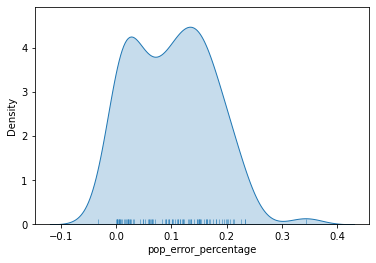

In [17]:
sns.kdeplot(municipalities['pop_error_percentage'], fill=True)
sns.rugplot(municipalities['pop_error_percentage'], alpha=0.5)

We can see that there are only a few outliers above 20% missing, and there seems to be somewhat natural groupings around 5% and 15%.
The single outlier at around 35% is the island Læsø (excluding Christiansø, which has a 100% error).

The single outlier below 0% is Ballerup, which may have (in our analysis) absorbed some settlements that stretches across multiple municipalities.

We can draw out and exaggerate these groups with a fisher-jenkins choropleth map with very few bins.

In [18]:
municipalities.loc[municipalities['pop_error_percentage'].idxmin()]['name']

'Ballerup'

In [19]:
municipalities.loc[municipalities['pop_error_percentage'].idxmax()]['name']

'Læsø'

(418947.1784999999, 915361.8115000001, 6032159.338500001, 6419932.9114999985)

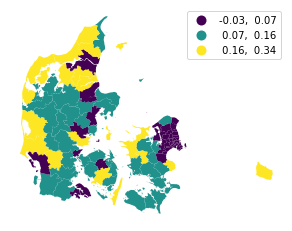

In [20]:
ax = municipalities.plot(
    column='pop_error_percentage',
    scheme='fisher_jenks',
    legend=True,
    k=3
)
ax.axis('off')

This plot lets us clearly see that the most urbanized areas of Denmark (Aalborg, Aarhus, Copenhagen, Odense) have the lowest error percentage.
This seems to support our suspicion that certain parts of the country have populations not represented by the settlement polygons.
In the most extreme case, almost 35 percent of citizens are not represented (the island Læsø in yellow).

From this we can conclude that the analysis we make going forward will fail to include over 20% of the population in certain areas, and those excluded are predominantly in non-urban areas of the country.

### Absolute population error

Now that we have an idea of how inacurrate our population data are in relative terms, we should turn to the question of how many people we are missing in absolute terms.

This is for multiple reasons.
Among them is the consideration that a municipality may contain both some more urbanised or 'settled' areas as well as more rural. In that case, the large urban population may 'mask' the excluded population in the above graph.
Conversely, a municipality with a very low number of inhabitants can appear more extreme if we only consider proportions.

In [21]:
municipalities['pop_error'] = municipalities['population'] - municipalities['population_settlement_sum']

In [22]:
municipalities['pop_error'].describe

<bound method NDFrame.describe of 0     5056.0
1     4286.0
2      126.0
3      -47.0
4     7870.0
       ...  
94    4116.0
95    3920.0
96     838.0
97     145.0
98       NaN
Name: pop_error, Length: 99, dtype: float64>

<AxesSubplot:xlabel='pop_error', ylabel='Density'>

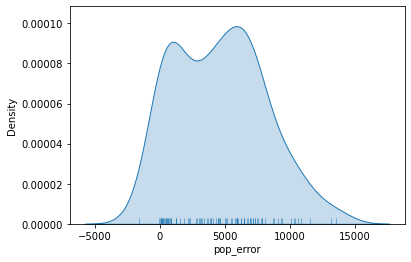

In [23]:
sns.kdeplot(municipalities['pop_error'], fill=True)
sns.rugplot(municipalities['pop_error'], alpha=0.5)

In [24]:
municipalities.loc[municipalities['pop_error'].idxmin()]['name']

'Ballerup'

Again, Ballerup is the minimal outlier.
We see a similar distribution, but now the tail is heavier - there is not just a single outlier.
If we use the same exaggerated technique to plot it

(418947.1784999999, 915361.8115000001, 6032159.338500001, 6419932.9114999985)

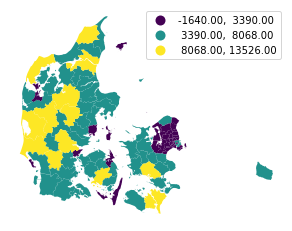

In [25]:
ax = municipalities.plot(
    column='pop_error',
    scheme='fisher_jenks',
    legend=True,
    k=3
)
ax.axis('off')

One observation is that many high-scoring municipalities in the percentage graph above have low scores here owing to their small number of inhabitants.

We also see that the most urbanised municipalities are now not the lowest scoring - probably owing to their high population - but they are not hiding significant populations.

Some places both have high percentage and high absolute excluded persons - such as parts of Eastern and Northern Jutland as well as Southern Funen.

Whereas coastal areas generally have the highest percentage of excluded inhabitants (see above), we see here that central Jutland appears as places that contain large numbers of excluded persons.

### National error

In [26]:
pop_denmark = municipalities['population'].sum()
pop_denmark

5961249

This number aligns perfectly with the [official national population count for January 2024](https://www.dst.dk/da/Statistik/emner/borgere/befolkning/befolkningstal).

In [27]:
total_error = pop_denmark - gdf['population'].sum()
total_error

449345

In [28]:
(total_error / pop_denmark) * 100

7.537765995012119

At a national scale, we see that we are missing about 7.5 % of the total population in our data.

While this is a meaningful source of error, it must be noted that it is unavoidable, as this simply reflects the fact that a certain percent of the population do not have an adress registered in a "settled" ("bebygget") area.
What is worth remembering is that the missing population is distributed unevenly in both absolute and relative terms, with 

## Areas and population density

Let's investigate the qualities of our shapes in terms of areas and population density.

<AxesSubplot:xlabel='area', ylabel='Density'>

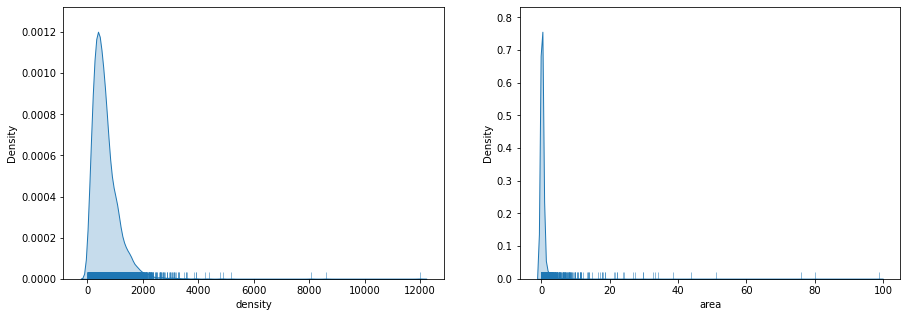

In [29]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(gdf['density'], fill=True, ax=ax1)
sns.rugplot(gdf['density'], alpha=0.5, ax=ax1)
sns.kdeplot(gdf['area'], fill=True, ax=ax2)
sns.rugplot(gdf['area'], alpha=0.5, ax=ax2)

First we note that the *overwhelming* majority of settlements have a small population density and small area.
New the question is, what is the relation between these variables?

### Visual inspection

We start with a visual inspection.
Categorizing the data in deciles based on density:

<AxesSubplot:>

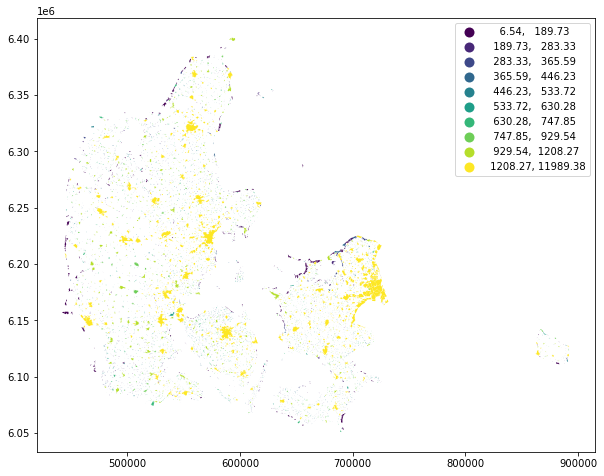

In [30]:
f, ax = plt.subplots(1, figsize=(10, 10))
gdf.plot('density', 
         legend=True, 
         ax=ax,
         scheme='quantiles',
         k=10
        )

Zooming into a region to better see details:

<AxesSubplot:>

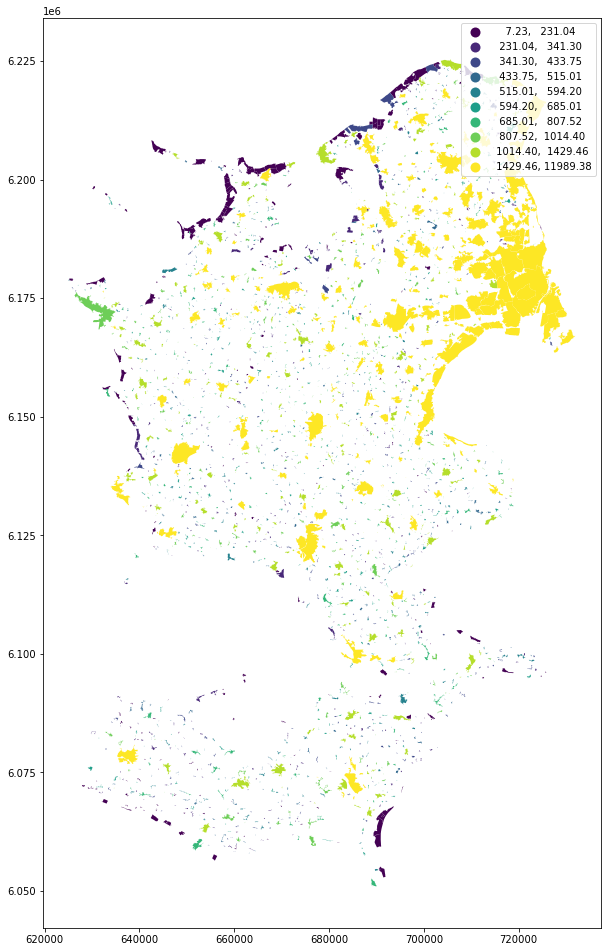

In [31]:
f, ax = plt.subplots(1, figsize=(10, 30))
gdf.cx[6.25e5:7.5e5, 6.05e6:6.25e6].plot('density', 
            legend=True, 
 #           figsize=(30, 30),
            ax=ax,
            scheme='quantiles',
            k=10
           )
# ax.set_ylim(6.05e6, 6.25e6)
# ax.set_xlim(6.2e5, 7.5e5);
# https://geopandas.org/en/stable/docs/user_guide/mapping.html
# https://learn.arcgis.com/en/paths/design-choropleth-maps/

Something interesting we can observe here is that it seems like the densest settlements are also the largest, except on the coast, where there are large, sparsely populated areas.

### Scatterplotting

Next, we scatterplot the density (x) and area (y) to see if there are visual similarities.
The first plot contains all data. The next is zoomed in to exclude the extreme outliers, the final is zoomed in to show a "valley" with a wall of large, sparsely populated settlements on one side, large, highly populated settlements on the other, and a floor of small sized sparsely to medium populated settlements.

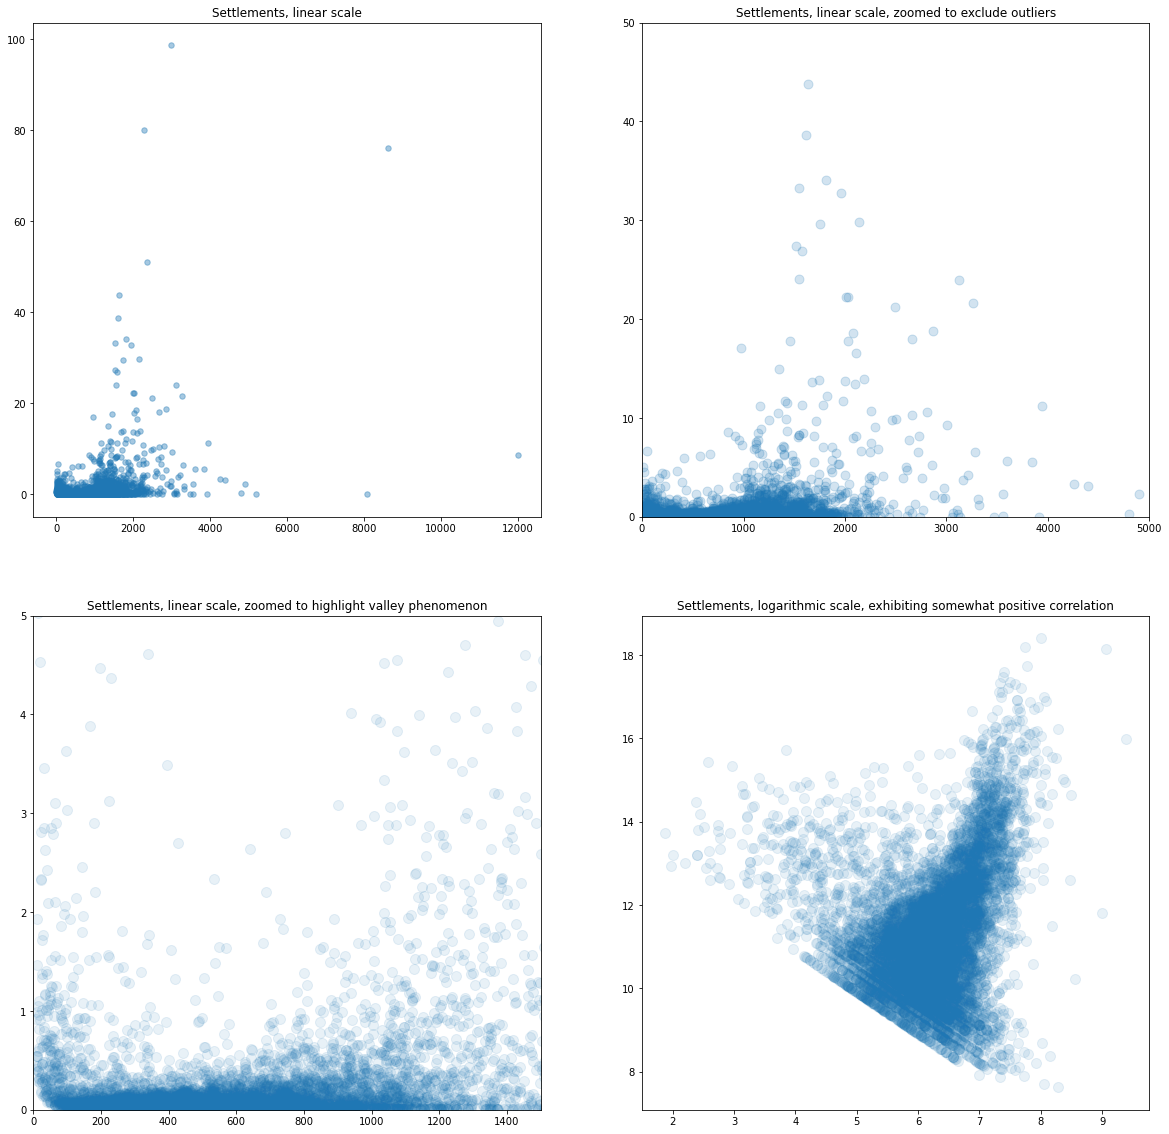

In [52]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(20,20))
ax1.scatter(gdf['density'], gdf['area'], s=30, alpha=0.4)
ax2.scatter(gdf['density'], gdf['area'], s=80, alpha=0.2)
ax2.set_xlim(0,5000)
ax2.set_ylim(0,50)
ax3.scatter(gdf['density'], gdf['area'], s=100, alpha=0.1)
ax3.set_xlim(0,1500)
ax3.set_ylim(0,5)
ax4.scatter(np.log(gdf['density']), np.log(gdf['area']*1_000_000), s=100, alpha=0.1)
ax1.set_title("Settlements, linear scale")
ax2.set_title("Settlements, linear scale, zoomed to exclude outliers")
ax3.set_title("Settlements, linear scale, zoomed to highlight valley phenomenon")
ax4.set_title("Settlements, logarithmic scale, exhibiting somewhat positive correlation");
#ax.semilogy()

Testing for significant correlation. It should be noted that the data has a heavy tail and extreme values

I have not had any previous training in data science (I am from software design), so I am extra careful to test significance.

In [34]:
def correlationtests(totest):
    corr, p_value = pearsonr(totest['density'], totest['area'])
    # The classic correlation I am comfortable with - not good with skewed non-normal data
    print(f"Pearson correlation : {corr}")
    print(f"P: {p_value}")
    print(f"Significant? {p_value < 0.05}")
    print()

    # Spearman is better for non-normally distributed data
    corr, p_value = spearmanr(totest['area'], totest['density'])
    print(f"Spearman correlation: {corr}")
    print(f"P-value: {p_value}")
    print(f"Significant? {p_value < 0.05}")
    print()

    # Try to reduce extreme
    corr, p_value = pearsonr(np.log(totest['density']), np.log(totest['area']))
    print(f"Pearson correlation : {corr}")
    print(f"P: {p_value}")
    print(f"Significant? {p_value < 0.05}")
    print()


correlationtests(gdf)

Pearson correlation : 0.343203218805563
P: 5.30541323654519e-221
Significant? True

Spearman correlation: 0.2523664791062677
P-value: 5.163539458526225e-117
Significant? True

Pearson correlation : 0.18917591422833233
P: 1.194505274528987e-65
Significant? True



I feel confident saying that there is a small correlation between area and population density.

This could perhaps be explained by the fact that as urban areas developed boundaries between settlements have historically "melted together" administratively to form larger settlement areas, and so the larger areas are an indicator of urbanity, and urbanity is correlated with population density.

Still, we have not explained the "valley" phenomenon we observed above.
The next section tries to explain that.

### Summer house area versus towns

My theory is that the left "wall" of the above plot is mostly comprised of summer house areas.

Let's investigate this visually first.

In [44]:
buffered = gpd.GeoDataFrame(columns=['type','geometry'], geometry='geometry', crs=gdf.crs)
buffered['geometry'] = gdf['geometry'].buffer(700)
buffered['type'] = gdf['type']

<AxesSubplot:>

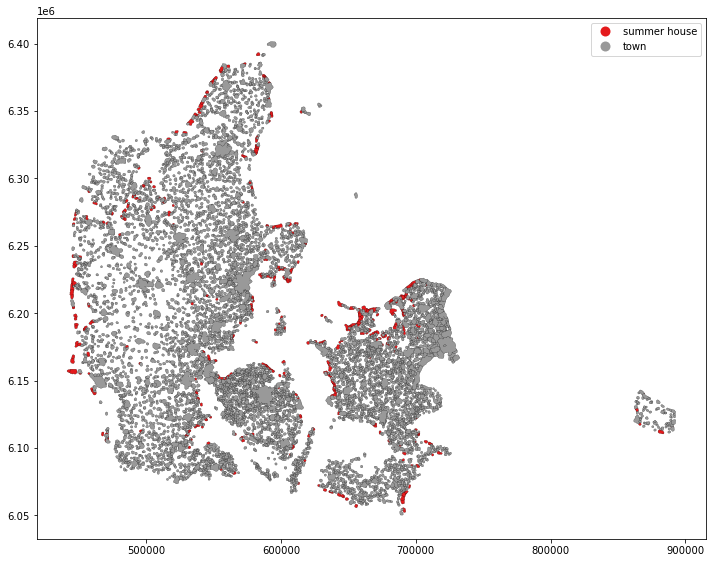

In [45]:
f, ax = plt.subplots(1, figsize=(12, 12))
buffered.plot('type', 
              legend=True, 
              ax=ax,
              cmap='Set1',
              linewidth=.2,
              categorical=True,
              edgecolor='black'
           )

Now I will repeat the above experiments, but this time seperately for summer house areas and other inhabited settlements ("towns").
I will both explore linear and logarithmicaly scaled data, as it is skewed quite noticably.

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Text(0.5, 0, 'Population per $km^2$')

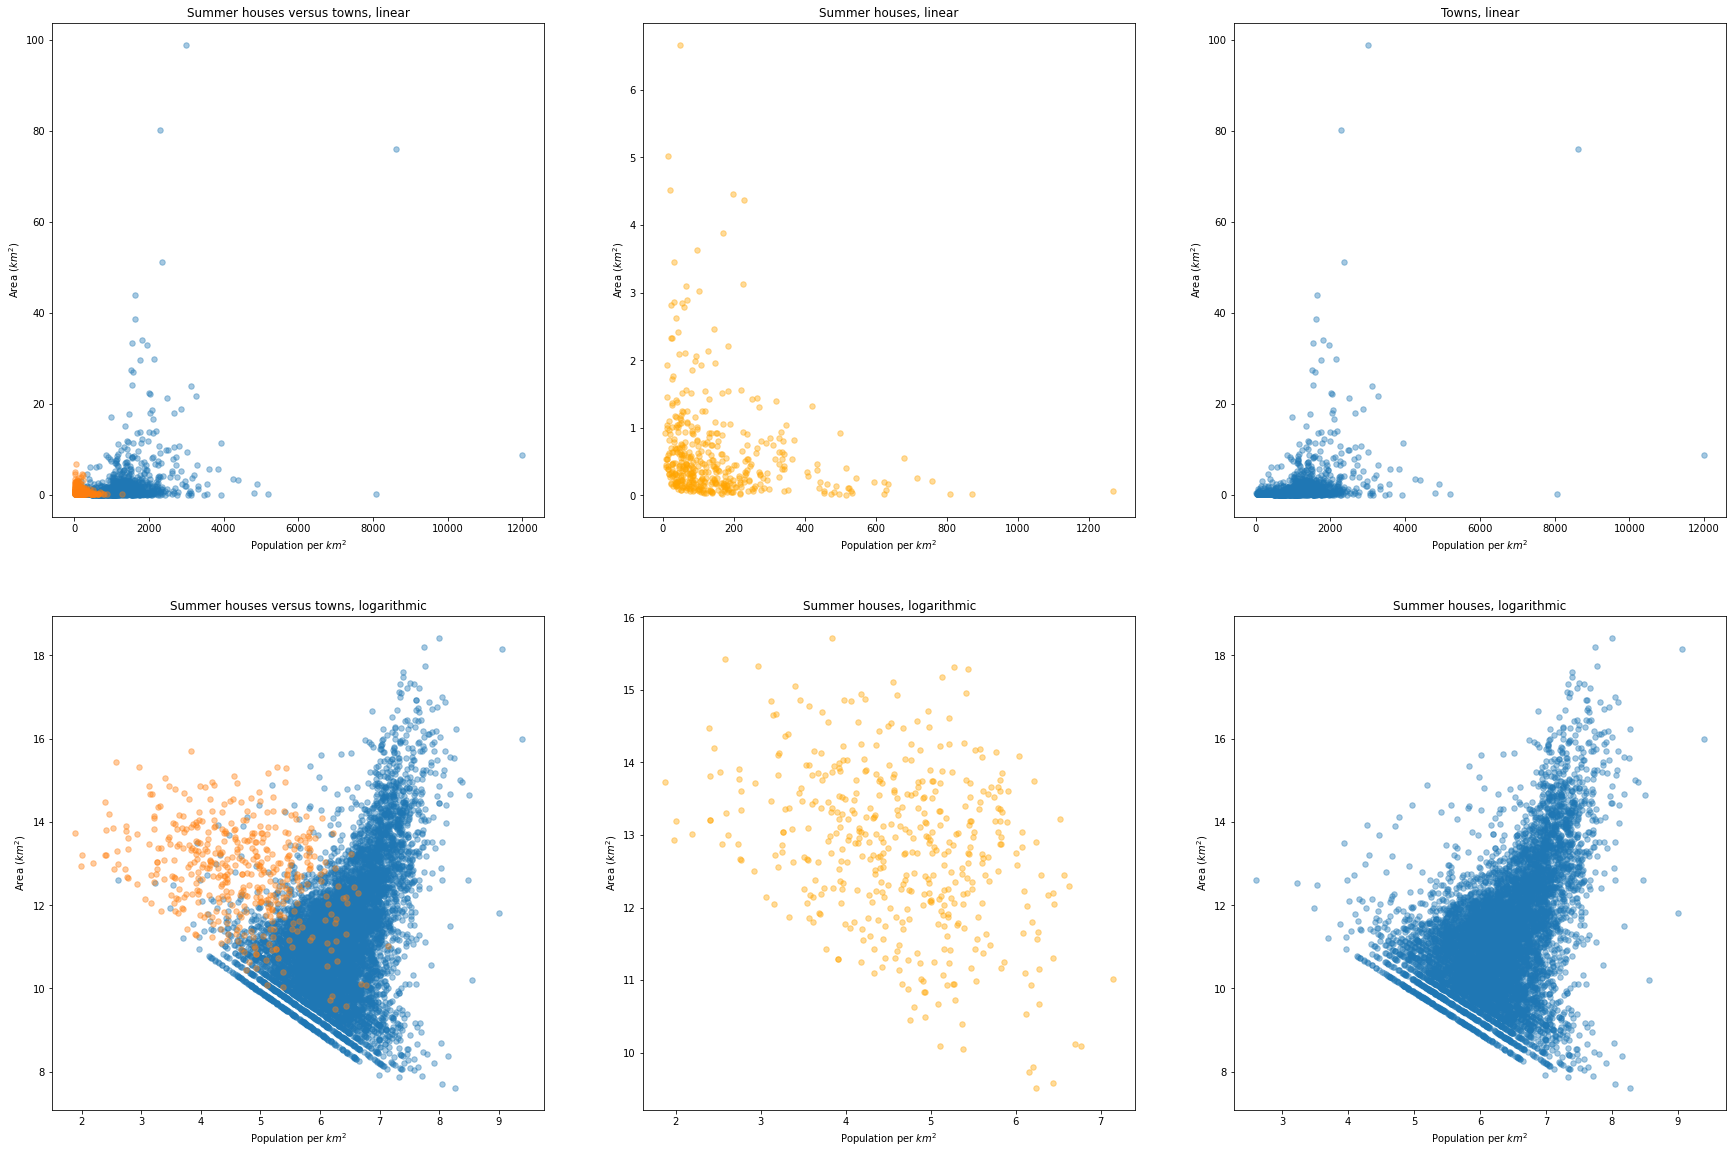

In [58]:
f, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2,3,figsize=(30,20))
# First, for towns
towns = gdf[gdf['type'] == 'town']
summerhouses = gdf[gdf['type'] == 'summer house']


ax1.scatter(towns['density'], towns['area'], s=30, alpha=0.4)
ax1.scatter(summerhouses['density'], summerhouses['area'], s=30, alpha=0.4)
ax2.scatter(summerhouses['density'], summerhouses['area'], s=30, alpha=0.4, color='orange')
ax3.scatter(towns['density'], towns['area'], s=30, alpha=0.4)


# Then, for summer houses
summerhouses['density'] = np.log(summerhouses['density'])
summerhouses['area'] = np.log(summerhouses['area']*1_000_000)
towns['density'] = np.log(towns['density'])
towns['area'] = np.log(towns['area']*1_000_000)

# summerhouse = gdf[gdf['type'] == 'summer house']
ax4.scatter(towns['density'], towns['area'], s=30, alpha=0.4)
ax4.scatter(summerhouses['density'], summerhouses['area'], s=30, alpha=0.4)
ax5.scatter(summerhouses['density'], summerhouses['area'], s=30, alpha=0.4, color='orange')
ax6.scatter(towns['density'], towns['area'], s=30, alpha=0.4)

ax1.set_title("Summer houses versus towns, linear")
ax2.set_title("Summer houses, linear")
ax3.set_title("Towns, linear")
ax4.set_title("Summer houses versus towns, logarithmic")
ax5.set_title("Summer houses, logarithmic")
ax6.set_title("Summer houses, logarithmic")

ax1.set_ylabel("Area ($km^2$)")
ax1.set_xlabel("Population per $km^2$")
ax2.set_ylabel("Area ($km^2$)")
ax2.set_xlabel("Population per $km^2$")
ax3.set_ylabel("Area ($km^2$)")
ax3.set_xlabel("Population per $km^2$")
ax4.set_ylabel("Area ($km^2$)")
ax4.set_xlabel("Population per $km^2$")
ax5.set_ylabel("Area ($km^2$)")
ax5.set_xlabel("Population per $km^2$")
ax6.set_ylabel("Area ($km^2$)")
ax6.set_xlabel("Population per $km^2$")

In [61]:
print("Testing towns")
correlationtests(gdf[gdf['type'] == 'town'])
print()
print("Testing summer houses")
correlationtests(gdf[gdf['type'] == 'summer house'])

Testing towns
Pearson correlation : 0.36175781140342783
P: 1.0438470236612477e-233
Significant? True

Spearman correlation: 0.3717930120049078
P-value: 9.440349814124196e-248
Significant? True

Pearson correlation : 0.4034241901090615
P: 2.0832325198979884e-295
Significant? True


Testing summer houses
Pearson correlation : -0.19913054541471523
P: 2.6396738023186807e-05
Significant? True

Spearman correlation: -0.2950463381907823
P-value: 2.878489575418782e-10
Significant? True

Pearson correlation : -0.3356595593652889
P: 5.069604110242032e-13
Significant? True



From exploring the data, we find that the difference between summer house areas and other inhabited settlements are quite noticable.

Whereas inhabited settlements tend to be more densely populated when they are larger, summer house areas tend to be less dense if they are larger.

This is an interesting observation that makes some sense when brought up, but which I did not consider at all before exploring the data.

# Other

In [ ]:
t = grf('sjaelland_stop-osm.geojson')

In [ ]:
t[t['bus'].isna()]['bus']

In [ ]:
merged[merged['name'] == 'Trustrup']